In [1]:
# Import useful packages
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir, path
import copy
import random

In [68]:
# Converts a rbg image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    if (len(image.shape) < 3):
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    new_image = cv2.Canny(new_image,30,100)           

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

# Load entire dataset
# Input: Dictionary of directories of images and their associated class, and 2-tuple representing size of the image
# Output: Features (N, image_size[1], image_size[2]) and class labels (N,), where N is the number of images in the dataset
def load_data(dir_dict, image_size):

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_dict:
        
        # Output is 0 for no, 1 for yes
        #y_val = 0
        #if directory.endswith('yes'):
            #y_val = 1
        
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(path.join(directory, filename), cv2.IMREAD_UNCHANGED)
            image = crop_brain_contour(image, plot=False) # Comment this out to use the unfiltered images
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_NEAREST)
            
            # Convert image to grayscale if necessary
            if len(image.shape) != 2:
                image = rgb2gray(image)
            
            # normalize values
            image = image / 255.
            
            # Add to dataset
            X.append(image)
            y.append(dir_dict[directory])
        
            
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data for good measure
    X, y = shuffle(X, y, random_state=0)

    #print(f'Number of examples is: {len(X)}')
    #print(f'X shape is: {X.shape}')
    #print(f'y shape is: {y.shape}')

    return X, y

# Split dataset
def split_data(X, y, test_s=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_s, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [69]:
def build_model(input_shape): # tuple in the shape of  model input ex: (image_width, image_height, #channels)

    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) 

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) 

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)  

    # FLATTEN X
    X = Flatten()(X)  
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X)  

    # Create model
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')

    return model

# Function which plots loss, accuracy, recall, precision and f1 of the trained model
def plot_metrics(history, train_f1, val_f1):

    # Get the metrics data
    keys = list(history)
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_recall = history[keys[3]]
    val_recall = history[keys[8]]
    train_precision = history[keys[4]]
    val_precision = history[keys[9]]
    
    
    # Plot Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch # - 1')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch # - 1')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Recall
    plt.figure()
    plt.plot(train_recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epoch # - 1')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

    # Plot Precision
    plt.figure()
    plt.plot(train_precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epoch # - 1')
    plt.ylabel('Precision')   
    plt.legend()
    plt.show()

    # Plot F1
    plt.figure()
    plt.plot(train_f1, label='Training F1-score')
    plt.plot(val_f1, label='Validation F1-Score')
    plt.title('F1-score')
    plt.xlabel('Epoch # - 1')
    plt.ylabel('F1-score')   
    plt.legend()
    plt.show()

In [70]:
# Defining useful variables
#dir_list = ['TumorIdentifier/no', 'TumorIdentifier/yes']
dir_dict = {'TumorDatasetFinal/no' : 0,
            'TumorDatasetFinal/yes' : 1
           }
image_size = (128, 128)

# Set random seeds
np.random.seed(0)
random.seed(0)

In [71]:
%%time
# Load dataset
X, y = load_data(dir_dict, image_size)

CPU times: user 6.21 s, sys: 1.55 s, total: 7.77 s
Wall time: 6.58 s


In [72]:
# Split dataset (80% train, 10% validation, 10% test)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(790, 128, 128)
(99, 128, 128)
(99, 128, 128)


In [73]:
# Build the convolutional network model (To re-train the model, re-run from this cell)
tf.random.set_seed(0) # Must reset the TensorFlow random seed every time we re-train the model

model = build_model((image_size[0],image_size[1],1))
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 132, 132, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 126, 126, 32)      1600      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 126, 126, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 31, 31, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 7, 7, 32)  

In [74]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [75]:
%%time

# Hyperparameters: mini-batch size and number of epochs
b_s = 10 # 10 to 110 skip 20
n_epochs = 20 # 10 to 20 skip 5

# Train the model
model.fit(x=X_train, y=y_train, batch_size=b_s, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/20
79/79 [==============================] - 11s 139ms/step - loss: 0.7813 - accuracy: 0.5962 - mse: 0.2656 - recall_8: 0.6202 - precision_8: 0.6158 - val_loss: 0.6502 - val_accuracy: 0.6162 - val_mse: 0.2290 - val_recall_8: 0.3333 - val_precision_8: 0.9000
Epoch 2/20
79/79 [==============================] - 9s 119ms/step - loss: 0.4904 - accuracy: 0.7709 - mse: 0.1614 - recall_8: 0.7957 - precision_8: 0.7752 - val_loss: 0.5908 - val_accuracy: 0.8081 - val_mse: 0.1997 - val_recall_8: 0.8148 - val_precision_8: 0.8302
Epoch 3/20
79/79 [==============================] - 9s 119ms/step - loss: 0.4090 - accuracy: 0.8177 - mse: 0.1292 - recall_8: 0.8365 - precision_8: 0.8208 - val_loss: 0.5781 - val_accuracy: 0.6667 - val_mse: 0.1959 - val_recall_8: 0.4630 - val_precision_8: 0.8621
Epoch 4/20
79/79 [==============================] - 10s 121ms/step - loss: 0.3630 - accuracy: 0.8392 - mse: 0.1124 - recall_8: 0.8413 - precision_8: 0.8516 - val_loss: 0.4914 - val_accuracy: 0.8081 - val_mse

In [76]:
# For plotting the metrics
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
mse
recall_8
precision_8
val_loss
val_accuracy
val_mse
val_recall_8
val_precision_8


In [77]:
# Compute f1 measure
keys = list(history)

train_recall = np.array(history[keys[3]])
val_recall = np.array(history[keys[8]])
train_precision = np.array(history[keys[4]])
val_precision = np.array(history[keys[9]])

train_f1 = 2 * (train_precision * train_recall / (train_precision + train_recall))
val_f1 = 2 * (val_precision * val_recall / (val_precision + val_recall))

print(val_f1[val_f1.shape[0]-1])

# This part was used to store the last validation f1 score to an output for each hyper-parameter combination, since we are technically manually applying grid search
with open("Output/ConvNetF1.txt", "a") as output:
    s = 'epoch = ' + str(n_epochs) + ' | batch size = ' + str(b_s) + ' : ' + str(val_f1[val_f1.shape[0]-1]) + '\n'
    output.write(s)    

0.8909090887810573


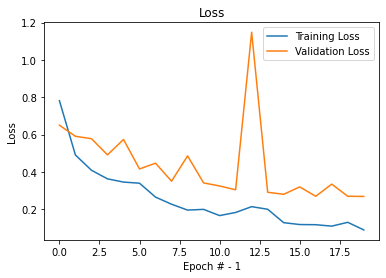

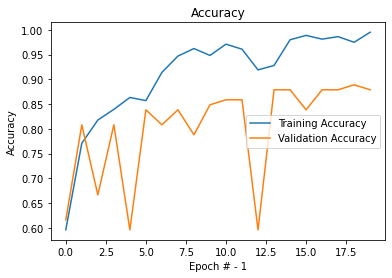

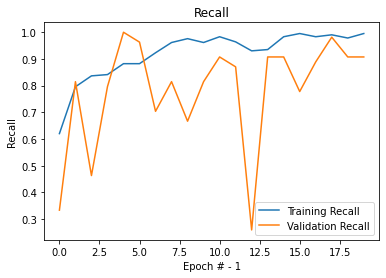

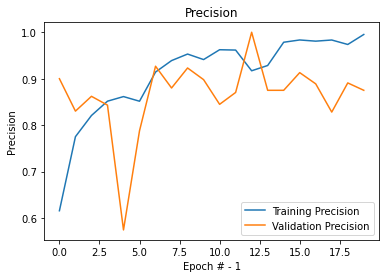

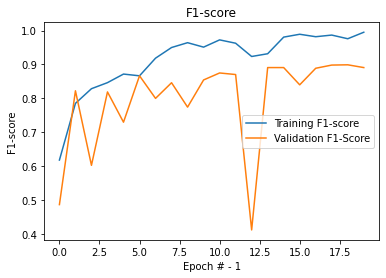

In [78]:
# Plot loss, accuracy, recall, precision and f1-score of training and validation data
plot_metrics(history, train_f1, val_f1)

In [79]:
# Predict on test set
y_pred_test = np.around(model.predict(X_test).reshape((-1))).astype('int32')

# Print classification report for test set
print(classification_report(y_test, y_pred_test, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.85      0.85      0.85        55
         yes       0.82      0.82      0.82        44

    accuracy                           0.84        99
   macro avg       0.84      0.84      0.84        99
weighted avg       0.84      0.84      0.84        99

